In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import warnings

warnings.filterwarnings('ignore')

# Load tables
df_performance_raw = pd.read_csv("../raw-data/benchmark.csv")

with open("../raw-data/r50_categories.json", "r") as f:
       r50_categories = json.load(f)

       categorized_resnets = []
       r50_category_inv_index = dict()
       for k, v in r50_categories.items():
              for vv in v:
                     categorized_resnets.append(vv)
                     r50_category_inv_index[vv] = k

# Filter out models that are not in the r50_categories
df_performance = df_performance_raw[df_performance_raw.model.isin(r50_category_inv_index.keys())]

# Compute new columns
df_performance["category"] = df_performance.model.apply(lambda x: r50_category_inv_index.get(x, None))
df_performance["ID"] = df_performance[["top1_acc/imagenet","top1_acc/imagenet-v2","top1_acc/imagenet-real"]].mean(axis=1)
df_performance["Robustness"] = df_performance[["top1_acc/imagenet-a","top1_acc/imagenet-c","top1_acc/imagenet-cbar"]].mean(axis=1)
df_performance["Concepts"] = df_performance[["top1_acc/imagenet-sketch","top1_acc/imagenet-r","top1_acc/stylized"]].mean(axis=1)
df_performance["Adversarial"] = df_performance[["top1_acc/PGD-40/low"]].mean(axis=1)

df_performance["LPP"] = df_performance[["metric/bandpass/LFC/0.1", "metric/bandpass/LFC/0.2", "metric/bandpass/LFC/0.3", "metric/bandpass/LFC/0.4", "metric/bandpass/LFC/0.5"]].mean(axis=1) 
df_performance["HPP"] = df_performance[["metric/bandpass/HFC/0.1", "metric/bandpass/HFC/0.2", "metric/bandpass/HFC/0.3", "metric/bandpass/HFC/0.4", "metric/bandpass/HFC/0.5"]].mean(axis=1) 

df_performance["Spectral Bias"] = df_performance["HPP"] / (df_performance["LPP"] + df_performance["HPP"])

mean_cols = ["ID", "Robustness", "Concepts", "Adversarial"]

# Create style helpers
category_to_color_map = dict(
       (k, plt.cm.tab10(i)) for i, k in enumerate(["stylized", "adversarial_training", "training_recipes", "freezing", "augmentation", "contrastive"])
)

category_to_color_map["baseline"] = (0, 0, 0)

category_to_color = lambda x: category_to_color_map[x]
model_to_category = lambda x: r50_category_inv_index[x]
model_to_color = lambda x: category_to_color(model_to_category(x))

all_markers = [".", "o", "h", "1", "2", "x", "D", "p", "8", "^", "<", ">", "v"]

model_to_marker_map = {}

for category, model_names in df_performance.groupby("category").model.apply(list).items():
       if category != "adversarial_training":
              for i, model_name in enumerate(model_names):
                     model_to_marker_map[model_name] = all_markers[i]
       else:
              for i, model_name in enumerate(model_names):
                     if "l2" in model_name:
                            model_to_marker_map[model_name] = "o"
                     else:
                            model_to_marker_map[model_name] = "s"

model_to_marker = lambda x: model_to_marker_map.get(x, "-")

def model_to_markersize(model):
       cat = model_to_category(model)
       if cat == "adversarial_training":
              return (float(model.split("eps")[-1]) + 1) / 5
       else:
              return 1

## Main Scatterplots

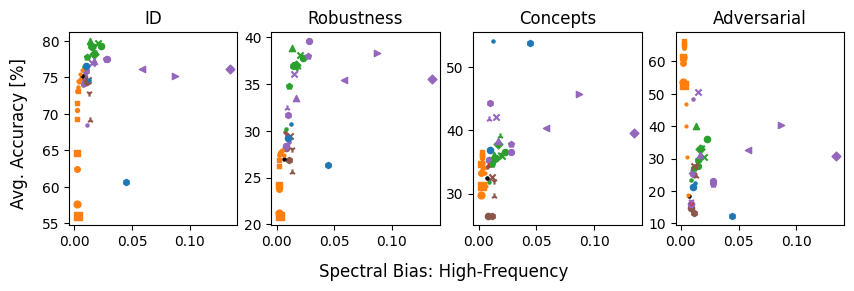

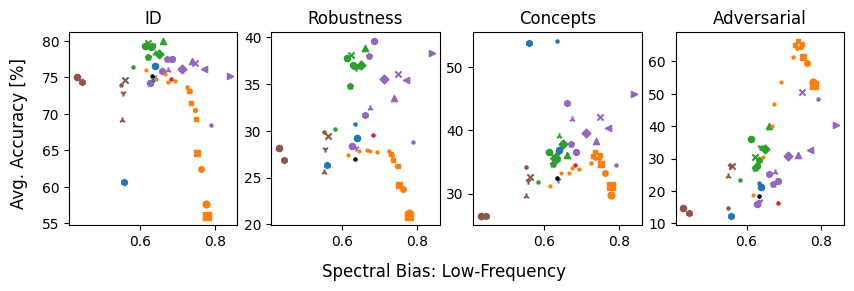

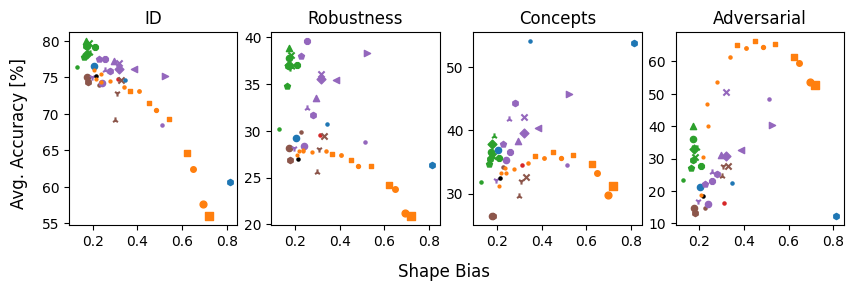

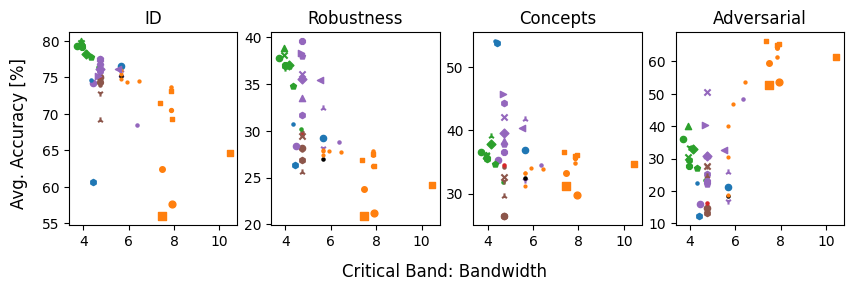

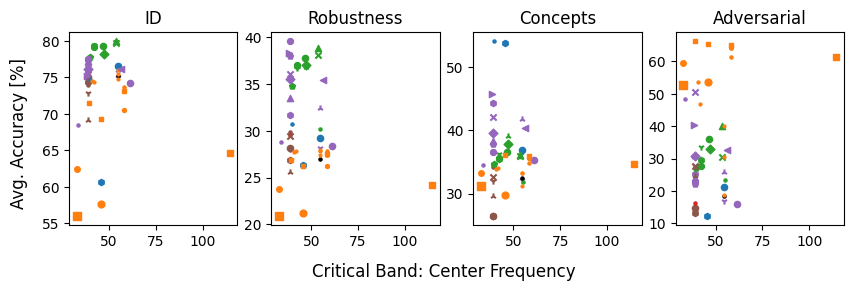

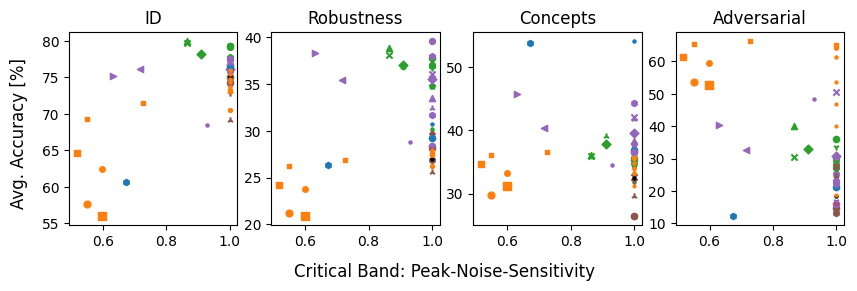

In [2]:
import matplotlib.pyplot as plt

def category_scatter(x_col, x_label, df=None):

    if df is None:
        df = df_performance

    fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))

    for ax, benchmark in zip(axes.ravel(), mean_cols):    

        dx = df[x_col].values
        dy = df[benchmark].values
        dhue = list(map(model_to_color, df.model))
        markers = list(map(model_to_marker, df.model))
        markersizes = list(map(model_to_markersize, df.model))

        for xx, yy, m, s, c in zip(dx, dy, markers, markersizes, dhue):
            ax.scatter(
                y=yy,
                x=xx,
                marker=m,
                s=s * 20,
                color=c
            )

        ax.set_title(benchmark)

    plt.subplots_adjust(hspace=0.3)

    fig.text(0.5, -0.1, x_label, ha='center', fontsize=12)
    fig.text(0.075, 0.475, 'Avg. Accuracy [%]', ha='center', va="center", rotation=90, fontsize=12)

pd.set_option("display.max_rows", None)

category_scatter("HPP", "Spectral Bias: High-Frequency")
category_scatter("LPP", "Spectral Bias: Low-Frequency")
category_scatter("shape-bias", "Shape Bias")
category_scatter("metric/criticalband/bw_norm", "Critical Band: Bandwidth")
category_scatter("metric/criticalband/cf_norm", "Critical Band: Center Frequency")
category_scatter("metric/criticalband/pns_norm", "Critical Band: Peak-Noise-Sensitivity")

## Low/highcut Filter Plots

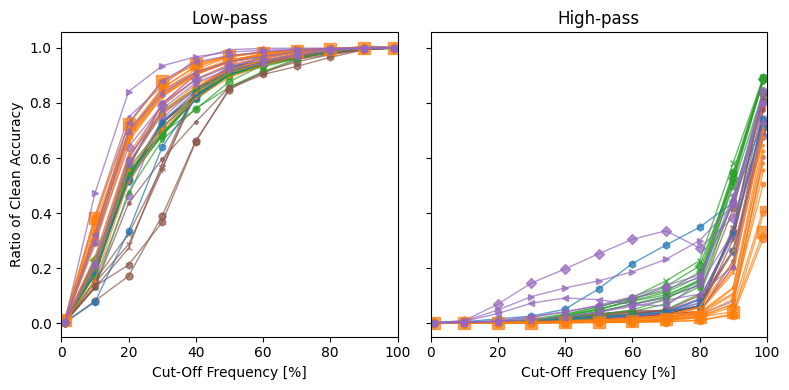

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=True, facecolor="w")

for bpass, ax in zip(["LFC", "HFC"], axes):
    for i, (index, row) in enumerate(df_performance.iterrows()):
        correct_cols = list(filter(lambda col: col.startswith(f"metric/bandpass/{bpass}/"), df_performance.columns))
        x = list(map(lambda s: float(s.replace(f"metric/bandpass/{bpass}/", "")) * 100, correct_cols))
        y = list(row[correct_cols].values) 

        ax.plot(x, y, 
                label=row.model, 
                lw=1 if row.category != "baseline" else 1,
                color=model_to_color(row.model),
                marker=model_to_marker(row.model),
                markersize = model_to_markersize(row.model) * 5,
                alpha=0.7,
                zorder=0 if row.category == "baseline" else 1,
        )
    ax.set_title({"LFC": "Low-pass", "HFC": "High-pass"}[bpass])
    ax.set_xlabel("Cut-Off Frequency [%]")
    if bpass == "LFC":
        ax.set_ylabel("Ratio of Clean Accuracy")
    ax.set_xlim(0, 100)
        
plt.tight_layout()